In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
import os
import random
import numpy as np

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
from torchvision import datasets, transforms

data_path = "/content/p1ch8/"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)

Files already downloaded and verified


In [5]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)

Files already downloaded and verified


In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [7]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

In [8]:
numel_list = [p.numel() for p in connected_model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [9]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [10]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [11]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [12]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [13]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [14]:
conv.weight.numel(), conv.bias.numel()

(432, 16)

In [15]:
# Alt:
[p.numel() for p in conv.parameters()]

[432, 16]

In [16]:
# Alt:
16 * 3 * 3 * 3, 16

(432, 16)

In [17]:
img, _ = cifar2[0]
img.shape

torch.Size([3, 32, 32])

In [18]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [19]:
img.mean(0).shape

torch.Size([32, 32])

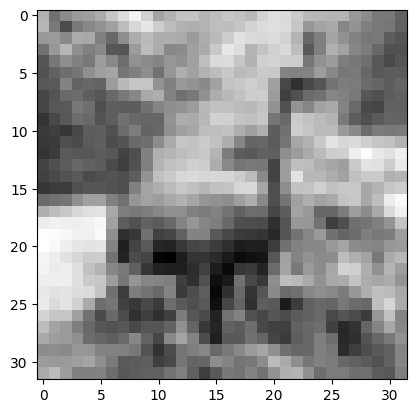

In [20]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

In [21]:
output[0, 0].shape

torch.Size([30, 30])

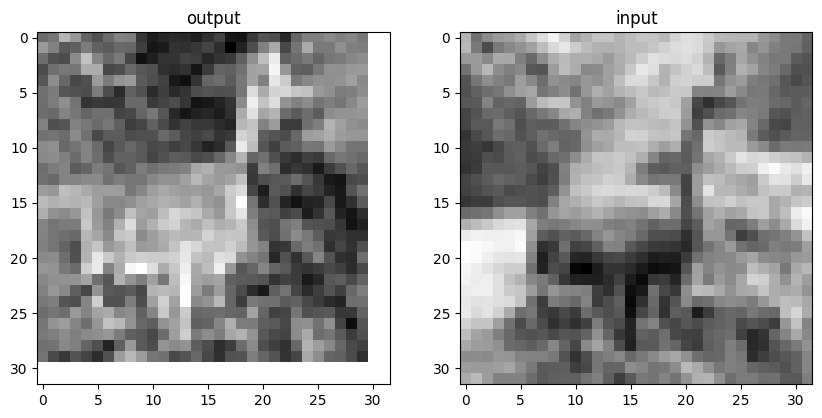

In [22]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray') # We call `detach` since we didn't use the `torch.no_grad()` context manager in the forward pass.
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig("Ch8_F2_PyTorch.png")
plt.show()

In [23]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [24]:
conv.bias.shape, conv.weight.shape

(torch.Size([1]), torch.Size([1, 3, 3, 3]))

In [25]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

print(conv.bias)
print(conv.weight)

Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]], requires_grad=True)


There are 9 elements in a 3 x 3 kernel. We're setting all of them to 1/9. And we're doing this for each of the 3 input channels.

In [26]:
output = conv(img.unsqueeze(0))
output.shape

torch.Size([1, 1, 32, 32])

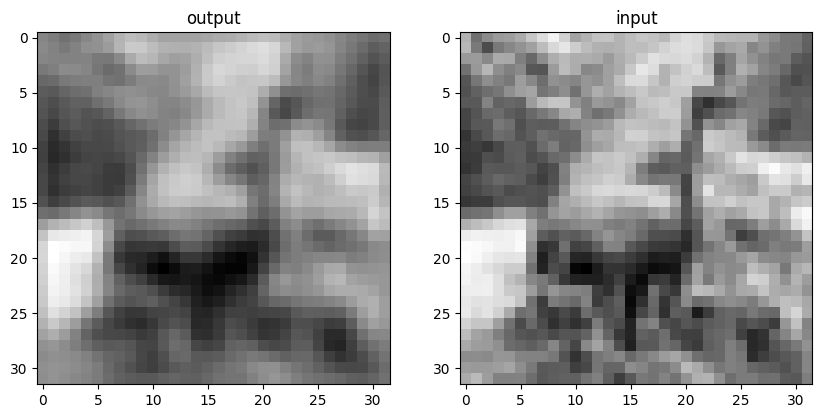

In [27]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig('Ch8_F4_PyTorch.png')
plt.show()

In [28]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv.weight.shape

torch.Size([1, 3, 3, 3])

In [29]:
conv.weight[:, :].shape

torch.Size([1, 3, 3, 3])

In [30]:
torch.tensor([[-1.0, 0.0, 1.0],
              [-1.0, 0.0, 1.0],
              [-1.0, 0.0, 1.0]]).shape

torch.Size([3, 3])

In [31]:
with torch.no_grad():
    conv.weight[:, :] = torch.tensor([[-1.0, 0.0, 1.0],
                                     [-1.0, 0.0, 1.0],
                                     [-1.0, 0.0, 1.0]]) # Works due to broadcasting.
    conv.bias.zero_()

print(conv.weight)
print(conv.bias)

Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [32]:
output = conv(img.unsqueeze(0))
output.shape

torch.Size([1, 1, 32, 32])

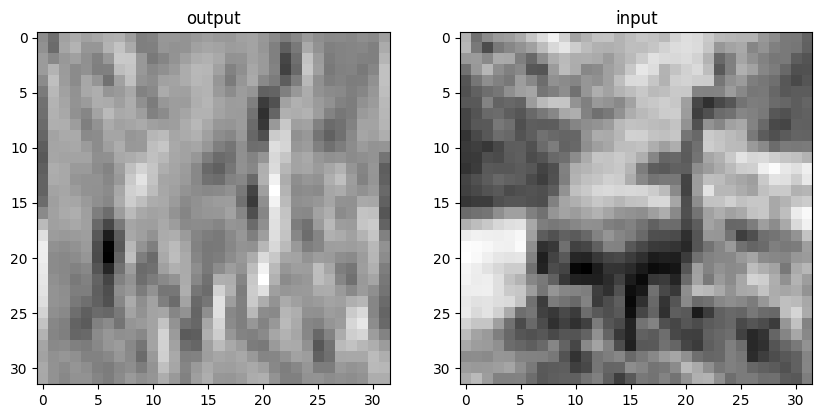

In [33]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.savefig('Ch8_F5_PyTorch.png')
plt.show()

In [34]:
pool = nn.MaxPool2d(kernel_size=2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [35]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2), # Images downsampled to 16x16.
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2), # Images downsamples to 8x8.
    # ...
)

In [36]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2), # Images downsampled to 16x16.
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2), # Images downsampled to 8x8.
    # ...
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [37]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [38]:
try:
    model(img.unsqueeze(0))
except RuntimeError as error:
    print(error)

mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)


In [39]:
64 * 8

512

Let's make our model work.

In [40]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2), # Images downsampled to 16x16.
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2), # Images downsampled to 8x8.
    nn.Flatten(), # This preserves the batch dimension.
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [41]:
model(img.unsqueeze(0))

tensor([[ 0.0621, -0.0586]], grad_fn=<AddmmBackward0>)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [43]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

**Note:** `nn.MaxPool2d` has a default stride of `2`.

In [44]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [45]:
# Test:
model(img.unsqueeze(0))

tensor([[0.0655, 0.2438]], grad_fn=<AddmmBackward0>)

In [46]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), kernel_size=2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), kernel_size=2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [47]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [48]:
# Test:
model(img.unsqueeze(0))

tensor([[ 0.0930, -0.0002]], grad_fn=<AddmmBackward0>)

In [49]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    # Note: All the parameters are mutable, and hence passed by reference.
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch: {}, Training Loss: {}".format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [51]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2024-03-06 11:27:35.304676 Epoch: 1, Training Loss: 0.5561451913824507
2024-03-06 11:28:06.842472 Epoch: 10, Training Loss: 0.3361944445189397
2024-03-06 11:28:40.348328 Epoch: 20, Training Loss: 0.29248801699489546
2024-03-06 11:29:13.493969 Epoch: 30, Training Loss: 0.2663489679337307
2024-03-06 11:29:46.951882 Epoch: 40, Training Loss: 0.24572152843710723
2024-03-06 11:30:20.675677 Epoch: 50, Training Loss: 0.22804634946926383
2024-03-06 11:30:54.051946 Epoch: 60, Training Loss: 0.2102011060164233
2024-03-06 11:31:27.953463 Epoch: 70, Training Loss: 0.19594413706451463
2024-03-06 11:32:01.121630 Epoch: 80, Training Loss: 0.1816796330367304
2024-03-06 11:32:34.910546 Epoch: 90, Training Loss: 0.1669914819727278
2024-03-06 11:33:08.926391 Epoch: 100, Training Loss: 0.1562015587452111


In [52]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct / total))

model.eval()
validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [53]:
torch.save(model.state_dict(), data_path + "birds_vs_airplanes.pt")

In [54]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt"))

<All keys matched successfully>

In [55]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training on device {device}.")

Training on device cuda.


In [56]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch: {}, Training Loss: {}".format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [57]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2024-03-06 11:33:12.705901 Epoch: 1, Training Loss: 0.576298225647325
2024-03-06 11:33:16.587379 Epoch: 10, Training Loss: 0.32699995824865474
2024-03-06 11:33:20.544955 Epoch: 20, Training Loss: 0.28877118590531076
2024-03-06 11:33:24.487707 Epoch: 30, Training Loss: 0.26167767029848826
2024-03-06 11:33:28.725139 Epoch: 40, Training Loss: 0.24454570219964739
2024-03-06 11:33:32.656073 Epoch: 50, Training Loss: 0.22419599120973782
2024-03-06 11:33:36.567200 Epoch: 60, Training Loss: 0.21188433624946387
2024-03-06 11:33:40.745628 Epoch: 70, Training Loss: 0.19629669469443095
2024-03-06 11:33:44.683303 Epoch: 80, Training Loss: 0.1808076724410057
2024-03-06 11:33:48.626337 Epoch: 90, Training Loss: 0.16689727369956908
2024-03-06 11:33:52.854354 Epoch: 100, Training Loss: 0.15307050672875847


In [58]:
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct / total))
        accdict[name] = correct / total
    return accdict

model.eval()
all_acc_dict['baseline'] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


In [59]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9391, 'val': 0.8925})])

An `OrderedDict` is a dictionary subclass that remembers the order in which keys were first inserted. The only difference between `dict` and `OrderedDict` lies in their handling of key order.

In [60]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt", map_location=device))

<All keys matched successfully>

In [61]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # `out_channels` increased from `16` to `32`.
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1) # `out_channels` increased from `8` to `16`.
        self.fc1 = nn.Linear(16 * 8 * 8, 32) # `in_channels` adjusted accordingly.
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), kernel_size=2) # Image downsampled to 16x16.
        out = F.max_pool2d(torch.tanh(self.conv2(out)), kernel_size=2) # Image downsampled to 8x8.
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [62]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

model.eval()
validate(model, train_loader, val_loader)

2024-03-06 11:33:53.567217 Epoch: 1, Training Loss: 0.5401903187773031
2024-03-06 11:33:57.226925 Epoch: 10, Training Loss: 0.3071437873847925
2024-03-06 11:34:01.283057 Epoch: 20, Training Loss: 0.2652527189748302
2024-03-06 11:34:05.590879 Epoch: 30, Training Loss: 0.23521585155064892
2024-03-06 11:34:09.711266 Epoch: 40, Training Loss: 0.21103401045510722
2024-03-06 11:34:13.840662 Epoch: 50, Training Loss: 0.18869682671917473
2024-03-06 11:34:18.130277 Epoch: 60, Training Loss: 0.16518395415442005
2024-03-06 11:34:22.197249 Epoch: 70, Training Loss: 0.14485609400898788
2024-03-06 11:34:26.440887 Epoch: 80, Training Loss: 0.12712943356982462
2024-03-06 11:34:30.602032 Epoch: 90, Training Loss: 0.11283869054287103
2024-03-06 11:34:34.682936 Epoch: 100, Training Loss: 0.09370752709923656
Accuracy train: 0.97
Accuracy val: 0.90


{'train': 0.9679, 'val': 0.9025}

In [63]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((n_chans1 // 2) * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), kernel_size=2) # Image downsampled to 16x16.
        out = F.max_pool2d(torch.tanh(self.conv2(out)), kernel_size=2) # Image downsampled to 8x8.
        out = out.view(-1, (self.n_chans1 // 2) * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [64]:
model = NetWidth(n_chans1=32).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

model.eval()
all_acc_dict['width'] = validate(model, train_loader, val_loader)

2024-03-06 11:34:35.385184 Epoch: 1, Training Loss: 0.5427224687330282
2024-03-06 11:34:39.333074 Epoch: 10, Training Loss: 0.3149552768582751
2024-03-06 11:34:43.435192 Epoch: 20, Training Loss: 0.27427627070314564
2024-03-06 11:34:47.530765 Epoch: 30, Training Loss: 0.2386593187975276
2024-03-06 11:34:51.855409 Epoch: 40, Training Loss: 0.21116564218785353
2024-03-06 11:34:55.961254 Epoch: 50, Training Loss: 0.18518928087251202
2024-03-06 11:35:00.064050 Epoch: 60, Training Loss: 0.1623184220141666
2024-03-06 11:35:04.449714 Epoch: 70, Training Loss: 0.14207059897150204
2024-03-06 11:35:08.547982 Epoch: 80, Training Loss: 0.12201038470408719
2024-03-06 11:35:12.737684 Epoch: 90, Training Loss: 0.10347044634021771
2024-03-06 11:35:17.053573 Epoch: 100, Training Loss: 0.08482230570950326
Accuracy train: 0.97
Accuracy val: 0.90


In [65]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9391, 'val': 0.8925}),
             ('width', {'train': 0.9709, 'val': 0.902})])

In [66]:
sum(p.numel() for p in model.parameters())

38386

Manual implementation of weight decay:

In [67]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch: {}, Training Loss: {}".format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

**Note:** This imples that the training loss values aren't comparable among models trained with different amounts of weight decay. (The value of `l2_lambda` impacts the overall loss calculation.)

In [68]:
model = NetWidth().to(device) # Note: We're training `NetWidth` for an apples-to-apples comparison with `NetDropout` & `NetBatchNorm`.
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop_l2reg(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

model.eval()
all_acc_dict['l2reg'] = validate(model, train_loader, val_loader)

2024-03-06 11:35:17.963075 Epoch: 1, Training Loss: 0.5609993055747573
2024-03-06 11:35:22.917515 Epoch: 10, Training Loss: 0.349700159992382
2024-03-06 11:35:28.699095 Epoch: 20, Training Loss: 0.30974512969612317
2024-03-06 11:35:34.211696 Epoch: 30, Training Loss: 0.2774402324561101
2024-03-06 11:35:39.997475 Epoch: 40, Training Loss: 0.25555872836500215
2024-03-06 11:35:45.430290 Epoch: 50, Training Loss: 0.23643428272312614
2024-03-06 11:35:51.230144 Epoch: 60, Training Loss: 0.21932714769415035
2024-03-06 11:35:56.666061 Epoch: 70, Training Loss: 0.2045877606246122
2024-03-06 11:36:02.436271 Epoch: 80, Training Loss: 0.19210988852628477
2024-03-06 11:36:07.872928 Epoch: 90, Training Loss: 0.18155105592338902
2024-03-06 11:36:13.652297 Epoch: 100, Training Loss: 0.1713599580678211
Accuracy train: 0.95
Accuracy val: 0.89


In [69]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9391, 'val': 0.8925}),
             ('width', {'train': 0.9709, 'val': 0.902}),
             ('l2reg', {'train': 0.9473, 'val': 0.8945})])

In [70]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear((n_chans1 // 2) * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), kernel_size=2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), kernel_size=2)
        out = self.conv2_dropout(out)
        out = out.view(-1, (self.n_chans1 // 2) * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

**Note:** Dropout is added after the max pooling operation.

In [71]:
model = NetDropout(n_chans1=32).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

model.eval()
all_acc_dict['dropout'] = validate(model, train_loader, val_loader)

2024-03-06 11:36:14.418741 Epoch: 1, Training Loss: 0.5788242691641401
2024-03-06 11:36:18.414046 Epoch: 10, Training Loss: 0.3836629225569925
2024-03-06 11:36:22.788402 Epoch: 20, Training Loss: 0.35145934334226475
2024-03-06 11:36:27.458671 Epoch: 30, Training Loss: 0.3350278983829887
2024-03-06 11:36:31.848365 Epoch: 40, Training Loss: 0.3164962719959818
2024-03-06 11:36:36.425428 Epoch: 50, Training Loss: 0.3049784651037994
2024-03-06 11:36:40.850711 Epoch: 60, Training Loss: 0.28954225436897035
2024-03-06 11:36:45.214897 Epoch: 70, Training Loss: 0.276699211472159
2024-03-06 11:36:49.882101 Epoch: 80, Training Loss: 0.2649793658571638
2024-03-06 11:36:54.283516 Epoch: 90, Training Loss: 0.25032516236707664
2024-03-06 11:36:58.735804 Epoch: 100, Training Loss: 0.2448678303296399
Accuracy train: 0.92
Accuracy val: 0.90


**Note:** It's better to subsume the `model.train()` call in the `training_loop` function and the `model.eval()` call in the `validate` function.

In [72]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9391, 'val': 0.8925}),
             ('width', {'train': 0.9709, 'val': 0.902}),
             ('l2reg', {'train': 0.9473, 'val': 0.8945}),
             ('dropout', {'train': 0.9243, 'val': 0.8955})])

In [73]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = 32
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear((n_chans1 // 2) * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), kernel_size=2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), kernel_size=2)
        out = out.view(-1, (self.n_chans1 // 2) * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [74]:
model = NetBatchNorm(n_chans1=32).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

model.eval()
all_acc_dict['batch_norm'] = validate(model, train_loader, val_loader)

2024-03-06 11:36:59.646846 Epoch: 1, Training Loss: 0.46925508624808804
2024-03-06 11:37:04.081321 Epoch: 10, Training Loss: 0.2729012681420442
2024-03-06 11:37:08.848488 Epoch: 20, Training Loss: 0.21827447604221903
2024-03-06 11:37:13.873121 Epoch: 30, Training Loss: 0.17240679380335625
2024-03-06 11:37:18.660343 Epoch: 40, Training Loss: 0.13740891177847886
2024-03-06 11:37:23.659612 Epoch: 50, Training Loss: 0.10553262050554252
2024-03-06 11:37:28.481540 Epoch: 60, Training Loss: 0.07811625445392101
2024-03-06 11:37:33.259564 Epoch: 70, Training Loss: 0.05739064591159676
2024-03-06 11:37:38.279303 Epoch: 80, Training Loss: 0.03895486718055549
2024-03-06 11:37:43.080713 Epoch: 90, Training Loss: 0.03180030002229058
2024-03-06 11:37:48.126264 Epoch: 100, Training Loss: 0.023561357523486683
Accuracy train: 1.00
Accuracy val: 0.87


The final training loss is so much lower than `NetDropout`'s final training loss! This could be due to a combination of (i) faster convergence when batch norm is applied and (ii) dropout making life more difficult for `NetDropout` on the training set. The implication of (i) is that there is no need to train `NetBatchNorm` for so many epochs. In fact, this is causing the model to overfit.

In [75]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9391, 'val': 0.8925}),
             ('width', {'train': 0.9709, 'val': 0.902}),
             ('l2reg', {'train': 0.9473, 'val': 0.8945}),
             ('dropout', {'train': 0.9243, 'val': 0.8955}),
             ('batch_norm', {'train': 0.9962, 'val': 0.87})])

The gaps between the scores of the five models are too narrow to declare a winner.

From the gap between `NetBatchNorm`'s training and validation scores, it's clear that the model is overfitting.

For a fair comparison, we should report the best epoch's accuracy for each model (not the last epoch's accuracy).

In [76]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((n_chans1 // 2) * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), kernel_size=2) # Output shape: (bs, n_chans1, 16, 16)
        out = F.max_pool2d(torch.relu(self.conv2(out)), kernel_size=2) # Output shape: (bs, n_chans1 // 2, 8, 8)
        out = F.max_pool2d(torch.relu(self.conv3(out)), kernel_size=2) # Output shape: (bs, n_chans1 // 2, 4, 4)
        out = out.view(-1, (self.n_chans1 // 2) * 4 * 4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [77]:
model = NetDepth(n_chans1=32).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

model.eval()
all_acc_dict['depth'] = validate(model, train_loader, val_loader)

2024-03-06 11:37:48.955007 Epoch: 1, Training Loss: 0.6812638287331648
2024-03-06 11:37:53.111187 Epoch: 10, Training Loss: 0.36978293812958296
2024-03-06 11:37:57.742897 Epoch: 20, Training Loss: 0.31492549095563827
2024-03-06 11:38:02.583764 Epoch: 30, Training Loss: 0.27550361898674325
2024-03-06 11:38:07.132164 Epoch: 40, Training Loss: 0.24914982525786017
2024-03-06 11:38:12.042335 Epoch: 50, Training Loss: 0.2218995440727586
2024-03-06 11:38:16.617769 Epoch: 60, Training Loss: 0.19764642901481336
2024-03-06 11:38:21.306259 Epoch: 70, Training Loss: 0.1733819906404064
2024-03-06 11:38:26.161054 Epoch: 80, Training Loss: 0.15025587261292586
2024-03-06 11:38:30.791194 Epoch: 90, Training Loss: 0.13254946730081824
2024-03-06 11:38:35.650299 Epoch: 100, Training Loss: 0.11051423505992647
Accuracy train: 0.91
Accuracy val: 0.86


In [78]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9391, 'val': 0.8925}),
             ('width', {'train': 0.9709, 'val': 0.902}),
             ('l2reg', {'train': 0.9473, 'val': 0.8945}),
             ('dropout', {'train': 0.9243, 'val': 0.8955}),
             ('batch_norm', {'train': 0.9962, 'val': 0.87}),
             ('depth', {'train': 0.9084, 'val': 0.863})])

**Note:** The seed is impacting these results significantly, making the comparison tricky.

In [79]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((n_chans1 // 2) * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), kernel_size=2) # Output shape: (bs, n_chans1, 16, 16)
        out = F.max_pool2d(torch.relu(self.conv2(out)), kernel_size=2) # Output shape: (bs, n_chans1 // 2, 8, 8)
        input_conv3 = out # Output shape: (bs, n_chans1 // 2, 8, 8)
        output_conv3 = self.conv3(out) # Output shape: (bs, n_chans1 // 2, 8, 8)
        # Note: The above 2 shapes have to match.
        out = F.max_pool2d(torch.relu(output_conv3) + input_conv3, kernel_size=2) # Shape: (bs, n_chans1 // 2, 4, 4)
        out = out.view(-1, (self.n_chans1 // 2) * 4 * 4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

**Notes:**

1. For the addition of `output_conv3` and `input_conv3` to be valid (without broadcasting, which doesn't make sense in this case), the number of output channels of `self.conv3` has to be equal to the number of input channels.
2. For the addition of `output_conv3` and `input_conv3` to be valid, a stride 2 convolution cannot be used (as it will downsample the image to 4x4). -> Then how to use skip connections with stride 2 convolutions?
2. The addition is performed AFTER applying the ReLU activation.

Sanity check:

In [80]:
model = NetRes(n_chans1=32).to(device)
model

NetRes(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [81]:
batch = next(iter(train_loader))
batch[0].shape, batch[1].shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [82]:
batch[0] = batch[0].to(device)
with torch.no_grad():
    outputs = model(batch[0])
outputs.shape

torch.Size([64, 2])

In [83]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

model.eval()
all_acc_dict['res'] = validate(model, train_loader, val_loader)

2024-03-06 11:38:36.450531 Epoch: 1, Training Loss: 0.6461336267222265
2024-03-06 11:38:40.621518 Epoch: 10, Training Loss: 0.3233458504175684
2024-03-06 11:38:45.372902 Epoch: 20, Training Loss: 0.28846418914521577
2024-03-06 11:38:50.155406 Epoch: 30, Training Loss: 0.2542393450998956
2024-03-06 11:38:54.808149 Epoch: 40, Training Loss: 0.22392725863843965
2024-03-06 11:38:59.688406 Epoch: 50, Training Loss: 0.19263876573580085
2024-03-06 11:39:04.311358 Epoch: 60, Training Loss: 0.16757748966478997
2024-03-06 11:39:09.054025 Epoch: 70, Training Loss: 0.1501078316645258
2024-03-06 11:39:13.844513 Epoch: 80, Training Loss: 0.12484790285111992
2024-03-06 11:39:18.467252 Epoch: 90, Training Loss: 0.10550865894005557
2024-03-06 11:39:23.412045 Epoch: 100, Training Loss: 0.08440083389876375
Accuracy train: 0.97
Accuracy val: 0.90


In [84]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9391, 'val': 0.8925}),
             ('width', {'train': 0.9709, 'val': 0.902}),
             ('l2reg', {'train': 0.9473, 'val': 0.8945}),
             ('dropout', {'train': 0.9243, 'val': 0.8955}),
             ('batch_norm', {'train': 0.9962, 'val': 0.87}),
             ('depth', {'train': 0.9084, 'val': 0.863}),
             ('res', {'train': 0.9727, 'val': 0.895})])

In [85]:
bn = nn.BatchNorm2d(num_features=32)
bn

BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

As noted before, `num_features` is the number of input channels to the `nn.BatchNorm2d` layer.

In [86]:
bn.weight

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       requires_grad=True)

In [87]:
bn.weight.shape

torch.Size([32])

In [88]:
bn.bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [89]:
bn.bias.shape

torch.Size([32])

According to a footnote in the book chapter, the above batch norm layer will produce output distributions that **initially** have mean 0 and variance 1. Does this mean that `bn.bias` contains the running means and `bn.weight` contains the running variances / standard deviations. It appears so. Even their shapes are matching. (It seems like they are called 'bias' and 'weight' for compatibility with `nn.Module`'s structure.)

In [90]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super().__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.batch_norm.bias)
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

**Notes:**

1. The number of input channels & the number of output channels of the residual block is the same.
2. It doesn't have any max pooling layer, so the image isn't downsampled.

In [91]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        list_of_res_blocks = []
        for i in range(n_blocks):
            list_of_res_blocks.append(ResBlock(n_chans=n_chans1))
        self.res_blocks = nn.Sequential(*list_of_res_blocks)
        self.fc1 = nn.Linear(n_chans1 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), kernel_size=2) # Output shape: (bs, n_chans1, 16, 16)
        out = self.res_blocks(out) # Output shape: (bs, n_chans1, 16, 16)
        out = F.max_pool2d(torch.relu(out), kernel_size=2) # Output shape: (bs, n_chans1, 8, 8)
        out = out.view(-1, self.n_chans1 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

**Note:**

1. `self.conv1` is required to increase the number of channels from `3` to `n_chans1`. The same trick can used for transfer learning on black & white images using the pre-trained weights of a model trained on ImageNet, i.e., first pass the black & white images through a randomly initialized `nn.Conv2d(1, 3, kernel_size=3, padding=1)` layer. <a href="https://forums.fast.ai/t/black-and-white-images-on-vgg16/2479" target="_blank">From the fast.ai forums</a>: "*... stick a 3 filter convolutional layer that you train between the grayscale data and the pretrained model (make sure the pretrained weights are frozen before training)*". Try this on the FER2013 dataset.
2. Since downsampling isn't being performed in `self.res_blocks`, the receptive field of an output pixel of `self.res_blocks` is the roughly same as the receptive field of an input pixel of `self.res_blocks`. ("*Roughly*" because there will be a minor difference if we include padding in the receptive field calculation - like the book does.) While this isn't a big deal for CIFAR-2, it probably won't work for ImageNet.

Sanity check:

In [92]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device)
model

NetResDeep(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ResBloc

In [93]:
with torch.no_grad():
    outputs = model(batch[0])
outputs.shape

torch.Size([64, 2])

In [94]:
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

model.train()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

model.eval()
all_acc_dict['res_deep'] = validate(model, train_loader, val_loader)

2024-03-06 11:39:33.698694 Epoch: 1, Training Loss: 0.9384063095044178
2024-03-06 11:41:01.195615 Epoch: 10, Training Loss: 0.6434686559780388
2024-03-06 11:42:38.325148 Epoch: 20, Training Loss: 0.5498976802370351
2024-03-06 11:44:15.609816 Epoch: 30, Training Loss: 0.4782248080536059
2024-03-06 11:45:53.535538 Epoch: 40, Training Loss: 0.42047442922926254
2024-03-06 11:47:30.780295 Epoch: 50, Training Loss: 0.35933512079108293
2024-03-06 11:49:08.200569 Epoch: 60, Training Loss: 0.3379358974801507
2024-03-06 11:50:45.785665 Epoch: 70, Training Loss: 0.317554206083155
2024-03-06 11:52:23.178406 Epoch: 80, Training Loss: 0.28611153952635016
2024-03-06 11:54:00.441917 Epoch: 90, Training Loss: 0.2835543637822388
2024-03-06 11:55:37.764163 Epoch: 100, Training Loss: 0.23121758194486047
Accuracy train: 0.74
Accuracy val: 0.74


Hmm... The evaluation results seem suspicious. Let's try running the evaluation again.

In [95]:
model.eval()
all_acc_dict['res_deep'] = validate(model, train_loader, val_loader)

Accuracy train: 0.74
Accuracy val: 0.74


Now, let's put the model in training mode, and run the evaluation.

In [96]:
model.train()
all_acc_dict['res_deep'] = validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.88


Now, let's put the model back into evaluation mode, and run the evaluation.

In [97]:
model.eval()
all_acc_dict['res_deep'] = validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.88


How strange! This is quite dangerous. Image using batch norm in a unified training cum evaluation loop. The metrics reported after the initial `model.eval()` call will be incorrect!

In [98]:
all_acc_dict

OrderedDict([('baseline', {'train': 0.9391, 'val': 0.8925}),
             ('width', {'train': 0.9709, 'val': 0.902}),
             ('l2reg', {'train': 0.9473, 'val': 0.8945}),
             ('dropout', {'train': 0.9243, 'val': 0.8955}),
             ('batch_norm', {'train': 0.9962, 'val': 0.87}),
             ('depth', {'train': 0.9084, 'val': 0.863}),
             ('res', {'train': 0.9727, 'val': 0.895}),
             ('res_deep', {'train': 0.9067, 'val': 0.878})])

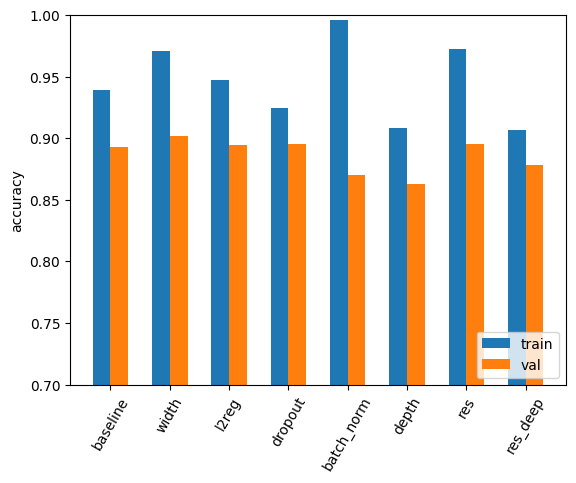

In [99]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width = 0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()